# DMW2 Lab 1: Clustering on Open Library Dataset
## Abstract

This study explores the patterns in the types of stories being produced across different regions, specifically books in Japanese (JPN), Korean (KOR), and Chinese (CHI), through by using Natural Language Processing (NLP) and machine learning techniques, as well as clustering and dimensionality reduction. Key attributes that were selected in the analysis were the book’s metadata, publishing information, content information, and structural information. Using Stopword Removal, One-Hot Encoding Languages, IF-IDF Vectorization, Truncated SVD, and feature standardization, the analysis was able to cluster Chinese literature on its own with Japanese and Korean literature combined into one. 

The Open Library dataset is a vast repository of bibliographic records, containing metadata for books from diverse languages, subjects, and publication periods. It includes key attributes such as titles, publish dates, languages, and subjects, making it a valuable resource for analyzing global literary trends.

The results demonstrate an interesting correlation between Korean and Japanese literature considering their history. The distinct separation with the clusters generated reinforces the idea that the history of a region may have an impact in the way that they structure their works. When Korea was annexed as a Japanese colony in the early 1900s, we can hypothesize that part of Japanese culture has left an influence on how Koreans subsequently developed their modern identity and creative works.

## Motivation
Literature has always been a reflection of cultural identity and shared experiences. In East Asia, historical narratives and storytelling techniques have created strong thematic parallels among Chinese, Japanese, and Korean literature. These similarities have influenced multiple works, from classical poetry and historical epics to certain aspects of modern fiction and non-fiction literature. However, as publishing landscapes evolve and global influences shape literary production, it is worth examining whether these common themes still hold or if each country has developed more distinct literary trajectories.

By analyzing publishing trends, we can better understand how literature is evolving in the region. Are there still strong thematic overlaps? Have modern publishing trends pushed each country’s literature in different directions? Through this research, we hope to gain insights into how literature continues to connect and differentiate the literary traditions of China, Japan, and Korea.

For this study, we outline three important parts of the methodology:
1. Data Extraction and Preprocessing
2. Feature Engineering
3. Clustering

We will discuss each section as we go along.

In [1]:
import os
import gzip
import json
import isbnlib
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
# data_base_path = "../data/"

In [3]:
def read_txt(file_path, total_lines, valid_cols):
    """
    Reads a tab-separated text file and extracts JSON data from the fifth column, 
    filtering it based on valid column keys.

    Parameters
    ----------
    file_path : str
        Path to the input text file.
    total_lines : int
        Estimated total number of lines in the file (used for tqdm progress bar).
    valid_cols : list of str
        List of valid keys to extract from the JSON data.

    Returns
    -------
    dict
        A dictionary where each key is a line index and the value is a dictionary 
        containing the extracted JSON fields that match `valid_cols`.
    """
    df_dict = {}
    
    with open(file_path, "r", encoding="utf-8") as infile:
        for idx, line in enumerate(tqdm(infile, total=total_lines, desc="Processing lines")):
            # if idx > 10000:
            #     break
            parts = line.strip().split("\t")
            
            if len(parts) < 5:
                continue 

            try:
                json_data = json.loads(parts[4])
                
                for key in json_data.keys():
                    df_dict[idx] = {key: json_data.get(key, np.nan) for key in valid_cols if key in json_data}
                
            except json.JSONDecodeError:
                continue

    return df_dict

## Data Extraction and Preprocessing

### Dataset Overview
The Open Library dataset contains of tab-separated text files that are compressed containing metadata of books, authors, and editions. Each line in the dataset represents a single record, where the fifth item contains metadata in JSON format. We opted to focus on the editions dataset ONLY as we found it to have the most information available. Given the size of the dataset, we focused on recent publications (2016 and later). To save on memory, we delete each file after accessing it.

### Key Parameters and Processing
The function extracts the following key attributes:
- Book Metadata: `"key"`, `"works"`, `"title"`
- Publishing Information: `"publishers"`, `"publish_date"`, `"publish_country"`
- Content Information: `"description"`, `"first_sentence"`, `"subjects"`, `"languages"`
- Structural Information: `"number_of_pages"`, `"latest_revision"`, `"revision"`

We preselected these JSON keys as we had identified them to be the most relevant to our analysis.

In [4]:
!zgrep -E '"publish_date": "(20(1[6-9]|[2-9][0-9]))([^"]*)?"' /mnt/data/public/openlibrary/20221007/ol_dump_editions_latest.txt.gz > editions_after_2015.txt

In [5]:
extracted_files = {
    "editions": {
        "file_path": "editions_after_2015.txt",
        "total_lines": 4259552,
    },
    "works": {
        "file_path": "filtered_works_with_editions.txt",
        "total_lines": 909883,
    },
    "authors": {
        "file_path": "filtered_authors_with_works_and_editions.txt",
        "total_lines": 853086,
    }
}

In [6]:
record_type = "editions"

ed_cols = [
    "key", "works", "title", "publishers", "description", "first_sentence", "subjects", "languages",
    "publish_date", "publish_country", "number_of_pages", "latest_revision", "revision"
]

file_path, total_lines = extracted_files[record_type]["file_path"], extracted_files[record_type]["total_lines"]
editions_dict = read_txt(file_path, total_lines, ed_cols)

Processing lines: 100%|██████████| 4259552/4259552 [03:11<00:00, 22293.84it/s]


In [7]:
!rm editions_after_2015.txt

### Data Cleaning

In this step, we preprocess and clean the Open Library Editions dataset to ensure high-quality data for further analysis. The main objectives of this code are to remove highly incomplete columns, standardize key fields, and filter out records with insufficient data.

#### Handling Missing Values
We first assessed the proportion of missing values across all columns in the dataset. We set the condition for dropping columns with more than 70% missing values. We found that this greatly reduced our dataset but improved quality.

#### Handling Specific Columns
**Publish Year**
- Extracts the first four characters (YYYY) from publish_date and converts them into integers.
- This ensures a numeric representation of the publish year for better analysis.

**Formatting Subjects**
- If a book has multiple subjects (stored as a list), they are joined into a single string separated by commas.
- This makes the subjects column easier to process in text-based analysis (e.g., TF-IDF).

**Standardizing Language Codes**
- The language information is stored as a list of dictionaries (e.g., `[{"key": "/languages/eng"}]`).
- This extracts the ISO language code (e.g., "eng", "jpn", "kor", "chi") for consistency.

**Removing Incomplete Entries**
- Any rows missing key fields (`title`, `languages`, `subjects`) are removed.
- The cleaned dataset is saved as `final_editions_df`.

In [8]:
editions_df = pd.DataFrame.from_dict(editions_dict, orient="index")
editions_df.head()

,key,works,title,publishers,description,publish_date,number_of_pages,latest_revision,revision,languages,subjects,publish_country,first_sentence
0,/books/OL24367788M,[{'key': '/works/OL15386091W'}],Akademia Canterwood: Wysokie Aspiracje,[PUBLICAT S. A.],"{'type': '/type/text', 'value': 'W elitarnym g...",2016,213.0,5.0,5,NaN,NaN,NaN,NaN
1,/books/OL25896697M,[{'key': '/works/OL17321171W'}],Too Blessed to Be Stressed,[Barbour],NaN,2016,NaN,4.0,4,NaN,NaN,NaN,NaN
2,/books/OL25896725M,[{'key': '/works/OL17321197W'}],"Fuera llueve, dentro también, ¿paso a buscarte?",[Montena],NaN,2016,NaN,3.0,3,NaN,NaN,NaN,NaN
3,/books/OL25898027M,[{'key': '/works/OL17322236W'}],Satin Island,[Pálido Fuego],NaN,2016,NaN,3.0,3,NaN,NaN,NaN,NaN
4,/books/OL25898429M,[{'key': '/works/OL17322587W'}],La península de Cilemaga,[Pregunta Ediciones],NaN,2016,NaN,4.0,4,NaN,NaN,NaN,NaN


In [9]:
del editions_dict

In [10]:
editions_df.shape

(4259552, 13)

In [11]:
editions_df.isna().sum() / len(editions_df) * 100

key                 0.000000
works               0.000610
title               0.000916
publishers          1.484264
description        98.352033
publish_date        0.000000
number_of_pages    70.451071
latest_revision     0.000047
revision            0.000000
languages           1.504712
subjects           69.716768
publish_country    97.697199
first_sentence     99.977556
dtype: float64

In [12]:
final_cols = ["key", "works", "title", "publishers", "publish_date", "languages", "subjects"]

drp_df = editions_df[final_cols]
del editions_df

In [13]:
drp_df["publishers"] = drp_df["publishers"].str[0]
drp_df["publishers"].fillna("Self-published", inplace=True)
drp_df["publish_year"] = ([int(x[:4]) for x in drp_df["publish_date"]])
drp_df["subjects"] = drp_df["subjects"].str.join(" ")
drp_df["works"] = drp_df["works"].apply(lambda x: x[0]["key"] if isinstance(x, list) and x else None)
drp_df["languages"] = drp_df["languages"].apply(
    lambda x: x[0]["key"].split("/")[-1] if isinstance(x, list) and x and "key" in x[0] else np.nan
)

final_editions_df = drp_df.dropna(subset=["title", "languages", "subjects"])

del drp_df

In [14]:
final_editions_df

,key,works,title,publishers,publish_date,languages,subjects,publish_year
67,/books/OL26450333M,/works/OL17868105W,West of Eden,Self-published,2016,eng,Social life and customs PERFORMING ARTS Histor...,2016
72,/books/OL26453406M,/works/OL17872089W,What you always wanted,Self-published,2016,eng,JUVENILE FICTION / Social Themes / Friendship ...,2016
82,/books/OL26474165M,/works/OL17897021W,The Kentucky cowboy's baby,Harlequin Books,2016,eng,Fiction Ranches Man-woman relationships Physic...,2016
87,/books/OL26487791M,/works/OL17912752W,Breakthrough,Self-published,2016,eng,Women presidents Women politicians Kvinnliga p...,2016
112,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,2016,chi,Zhang pian xiao shuo Er tong wen xue,2016
...,...,...,...,...,...,...,...,...
4259502,/books/OL39784786M,/works/OL28903893W,Abby's Pony Love,Hastings Creations Group,2022,eng,Children's fiction Pets,2022
4259516,/books/OL39786866M,/works/OL28852046W,Fea,KV Books LLC,2022,eng,"Fiction, lgbtq+, gay Fiction, general",2022
4259540,/books/OL39791850M,/works/OL28939362W,Sketch Tour of Yale University,Joseph Merritt Company,2022,eng,Architecture Art,2022
4259548,/books/OL39793914M,/works/OL28909366W,Is for Alexander,History Unboxed,2022,eng,Biography World history,2022


In [15]:
final_editions_df.dtypes

key             object
works           object
title           object
publishers      object
publish_date    object
languages       object
subjects        object
publish_year     int64
dtype: object

In [16]:
final_editions_df.languages.value_counts()

languages
eng    1238882
ger      11544
spa      10917
chi       8785
fre       4815
        ...   
nyn          1
nic          1
lin          1
gmh          1
tet          1
Name: count, Length: 152, dtype: int64

### EDA

In [17]:
east_asian_editions_df = final_editions_df[final_editions_df["languages"].isin(["jpn", "kor", "chi"])].drop("publish_date", axis=1)
east_asian_editions_df

,key,works,title,publishers,languages,subjects,publish_year
112,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,chi,Zhang pian xiao shuo Er tong wen xue,2016
133,/books/OL26926535M,/works/OL19713398W,Bu dong sa jiao de nü ren,U Media Global,chi,Television mini-series Chinese Television plays,2017
139,/books/OL26927601M,/works/OL19714463W,"Ren sheng a, zhen de shi mei xiang dao",Huang guan wen hua chu ban you xian gong si,chi,Chinese essays Anecdotes,2017
148,/books/OL26931282M,/works/OL19718151W,Bruno Grill Pot duo gong neng wen zhu guo you ...,Yan chu ban,chi,Slow Electric cooking Casserole cooking Intern...,2017
149,/books/OL26931336M,/works/OL19718205W,Chang bian,Huang guan chu ban she (Xianggang) you xian go...,chi,Alternative treatment Recipes Constipation Die...,2016
...,...,...,...,...,...,...,...
4248088,/books/OL34400939M,/works/OL25634311W,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Jiu,Zhejiang University Press,chi,"Labor laws and legislation, china Labor contra...",2016
4252711,/books/OL36621131M,/works/OL27015113W,Android ying yong ce shi zhi nan,Ren min you dian chu ban she,chi,Yi dong zhong duan Ying yong cheng xu Cheng xu...,2016
4252719,/books/OL36656364M,/works/OL19668089W,GRE shu xue gao fen kuai su tu po,Bei jing yu yan da xue chu ban she,chi,Gao deng shu xue Sheng xue can kao zi liao Shu...,2016
4254893,/books/OL37790532M,/works/OL27704560W,Qing qiu hu chuan shuo,Zhang jiang chu ban she,chi,Zhang pian xiao shuo,2016


In [18]:
del final_editions_df

In [19]:
east_asian_editions_df[east_asian_editions_df["key"]=="/books/OL37824312M"]

,key,works,title,publishers,languages,subjects,publish_year
4238208,/books/OL37824312M,/works/OL27719558W,Tang shiSong ci san bai shou,Bei jing lian he chu ban gong si,chi,Tang shi Shi ji Song ci Xuan ji,2016


In [20]:
east_asian_editions_df.shape

(11949, 7)

In [21]:
east_asian_editions_df.groupby("languages")["key"].nunique()

languages
chi    8785
jpn    2483
kor     681
Name: key, dtype: int64

In [22]:
east_asian_editions_df.reset_index(inplace=True)
east_asian_editions_df.drop("index", axis=1, inplace=True)

east_asian_editions_df

,key,works,title,publishers,languages,subjects,publish_year
0,/books/OL26869357M,/works/OL19649589W,Bai ma ke xin de xing kong,Si chuan wen yi chu ban she,chi,Zhang pian xiao shuo Er tong wen xue,2016
1,/books/OL26926535M,/works/OL19713398W,Bu dong sa jiao de nü ren,U Media Global,chi,Television mini-series Chinese Television plays,2017
2,/books/OL26927601M,/works/OL19714463W,"Ren sheng a, zhen de shi mei xiang dao",Huang guan wen hua chu ban you xian gong si,chi,Chinese essays Anecdotes,2017
3,/books/OL26931282M,/works/OL19718151W,Bruno Grill Pot duo gong neng wen zhu guo you ...,Yan chu ban,chi,Slow Electric cooking Casserole cooking Intern...,2017
4,/books/OL26931336M,/works/OL19718205W,Chang bian,Huang guan chu ban she (Xianggang) you xian go...,chi,Alternative treatment Recipes Constipation Die...,2016
...,...,...,...,...,...,...,...
11944,/books/OL34400939M,/works/OL25634311W,He Xie Lao Dong Guan Xi de Fa Lü Ji Zhi Yan Jiu,Zhejiang University Press,chi,"Labor laws and legislation, china Labor contra...",2016
11945,/books/OL36621131M,/works/OL27015113W,Android ying yong ce shi zhi nan,Ren min you dian chu ban she,chi,Yi dong zhong duan Ying yong cheng xu Cheng xu...,2016
11946,/books/OL36656364M,/works/OL19668089W,GRE shu xue gao fen kuai su tu po,Bei jing yu yan da xue chu ban she,chi,Gao deng shu xue Sheng xue can kao zi liao Shu...,2016
11947,/books/OL37790532M,/works/OL27704560W,Qing qiu hu chuan shuo,Zhang jiang chu ban she,chi,Zhang pian xiao shuo,2016


## Feature Engineering
This feature engineering pipeline prepares East Asian literary editions (Chinese, Japanese, and Korean) from the Open Library dataset for clustering analysis. The process includes text preprocessing, stopword removal, TF-IDF vectorization, dimensionality reduction, and feature scaling to create a structured numerical dataset.

### Stopword Removal
Given the scope of the dataset (East Asian literature), the Open Library dataset contained Romanized versions of Chinese, Japanese, and Korean text and we needed to account for Romanized forms during stopword removal. We utilized ChatGPT to come up with Romanized stopwords of the three languages.
- Removes stopwords in all four languages

### One-Hot Encoding for Language Feature
- Converts language labels (`chi`, `jpn`, `kor`) into separate binary columns (`languages_chi`, `languages_jpn`, `languages_kor`).
- Ensures the model treats languages as independent features.

### TF-IDF Vectorization for Title + Subjects
- Converts text into numerical vectors based on word importance.
- Limits features to 5,000 words to reduce sparsity.

### Dimensionality Reduction Using Truncated SVD
- Applies Truncated Singular Value Decomposition (SVD) to reduce dimensionality.
- Determines the number of components needed to retain 90% of variance

### Standardization of Features
- Ensures all features have zero mean and unit variance.
- Prevents bias from large numerical differences.

The final, numerical dataset now consists of metadata (year, language) and text-based features (TF-IDF matrix)

### Without stopwords

In [23]:
nltk.download("stopwords")
english_stopwords = set(stopwords.words("english"))
japanese_stopwords = {"no", "wa", "wo", "ga", "to", "de", "kekkon"}
korean_stopwords = {"ŭl", "rŭl", "nŭn", "i", "ga", "e", "eseo", "yuga"}
chinese_stopwords = {"de", "shi", "zai", "you", "ta", "cheng", "xu"}


def remove_stopwords(text, lang):
    words = text.lower().split()
    
    if lang == "chi":  # Chinese stopword removal
        words = [word for word in words if word not in chinese_stopwords]
    elif lang == "jpn":  # Japanese stopword removal
        words = [word for word in words if word not in japanese_stopwords]
    elif lang == "kor":  # Korean stopword removal
        words = [word for word in words if word not in korean_stopwords]
    elif lang == "eng":  # English stopword removal
        words = [word for word in words if word not in english_stopwords]
    
    return " ".join(words)

east_asian_editions_df["text"] = east_asian_editions_df["title"] + " " + east_asian_editions_df["subjects"]
east_asian_editions_df["stopwordsless"] = east_asian_editions_df.apply(lambda row: remove_stopwords(row["text"], row["languages"]), axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2025/jvalera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
lang_encoded = encoder.fit_transform(east_asian_editions_df[["languages"]])
lang_df = pd.DataFrame(lang_encoded, columns=encoder.get_feature_names_out(["languages"]))
df_encoded = pd.concat([east_asian_editions_df, lang_df], axis=1)

vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r"\b\w+\b")

tfidf_matrix = vectorizer.fit_transform(df_encoded["stopwordsless"])

svd = TruncatedSVD(n_components=min(tfidf_matrix.shape) - 1, random_state=42)
X_svd = svd.fit_transform(tfidf_matrix)

explained_variance = np.cumsum(svd.explained_variance_ratio_)
n_components = np.searchsorted(explained_variance, 0.90) + 1
print(f"Number of components to retain 90% variance: {n_components}")

svd = TruncatedSVD(n_components=1719, random_state=42)
X_svd = svd.fit_transform(tfidf_matrix)

X_final = pd.DataFrame(X_svd, columns=[f"SV {i+1}" for i in range(X_svd.shape[1])])
X_final[["publish_year", "languages_kor", "languages_jpn", "languages_chi"]] = df_encoded[["publish_year", "languages_kor", "languages_jpn", "languages_chi"]]

scaler = StandardScaler()
X_scaled_stopwords = scaler.fit_transform(X_final)

Number of components to retain 90% variance: 1719


## Clustering

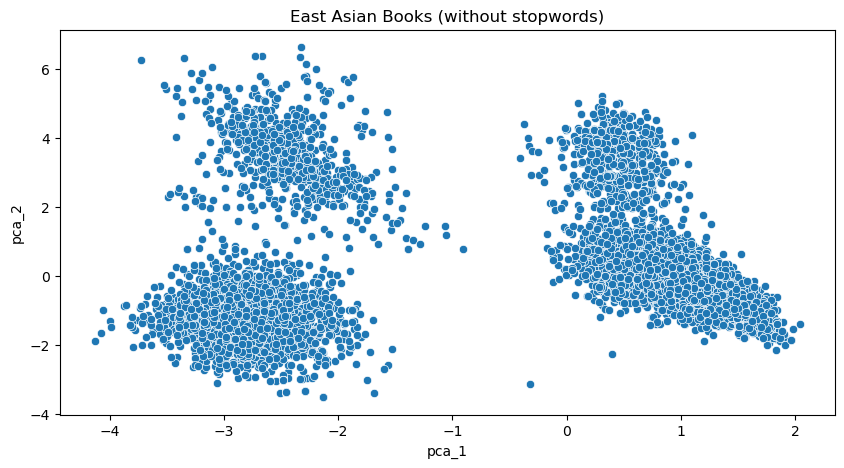

In [25]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled_stopwords)

df_encoded["pca_1"] = pca_result[:, 0]
df_encoded["pca_2"] = pca_result[:, 1]

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_encoded["pca_1"], y=df_encoded["pca_2"], palette="viridis")
plt.title("East Asian Books (without stopwords)")
plt.show()

### KMeans

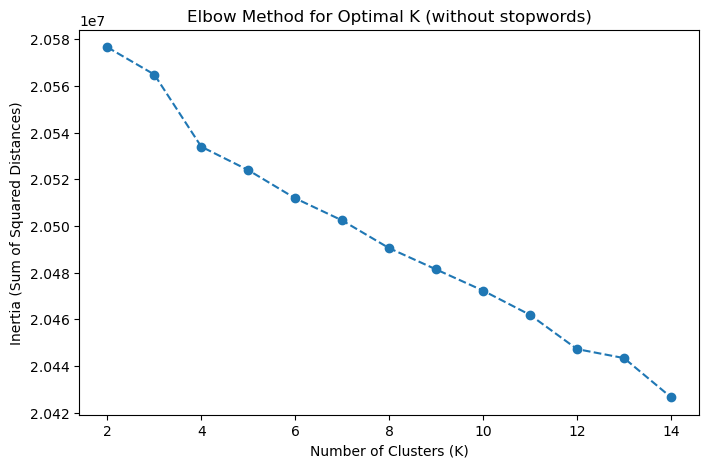

In [26]:
inertia_values = []
k_range = range(2, 15)  # Testing clusters from 2 to 14

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_stopwords)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K (without stopwords)")
plt.show()

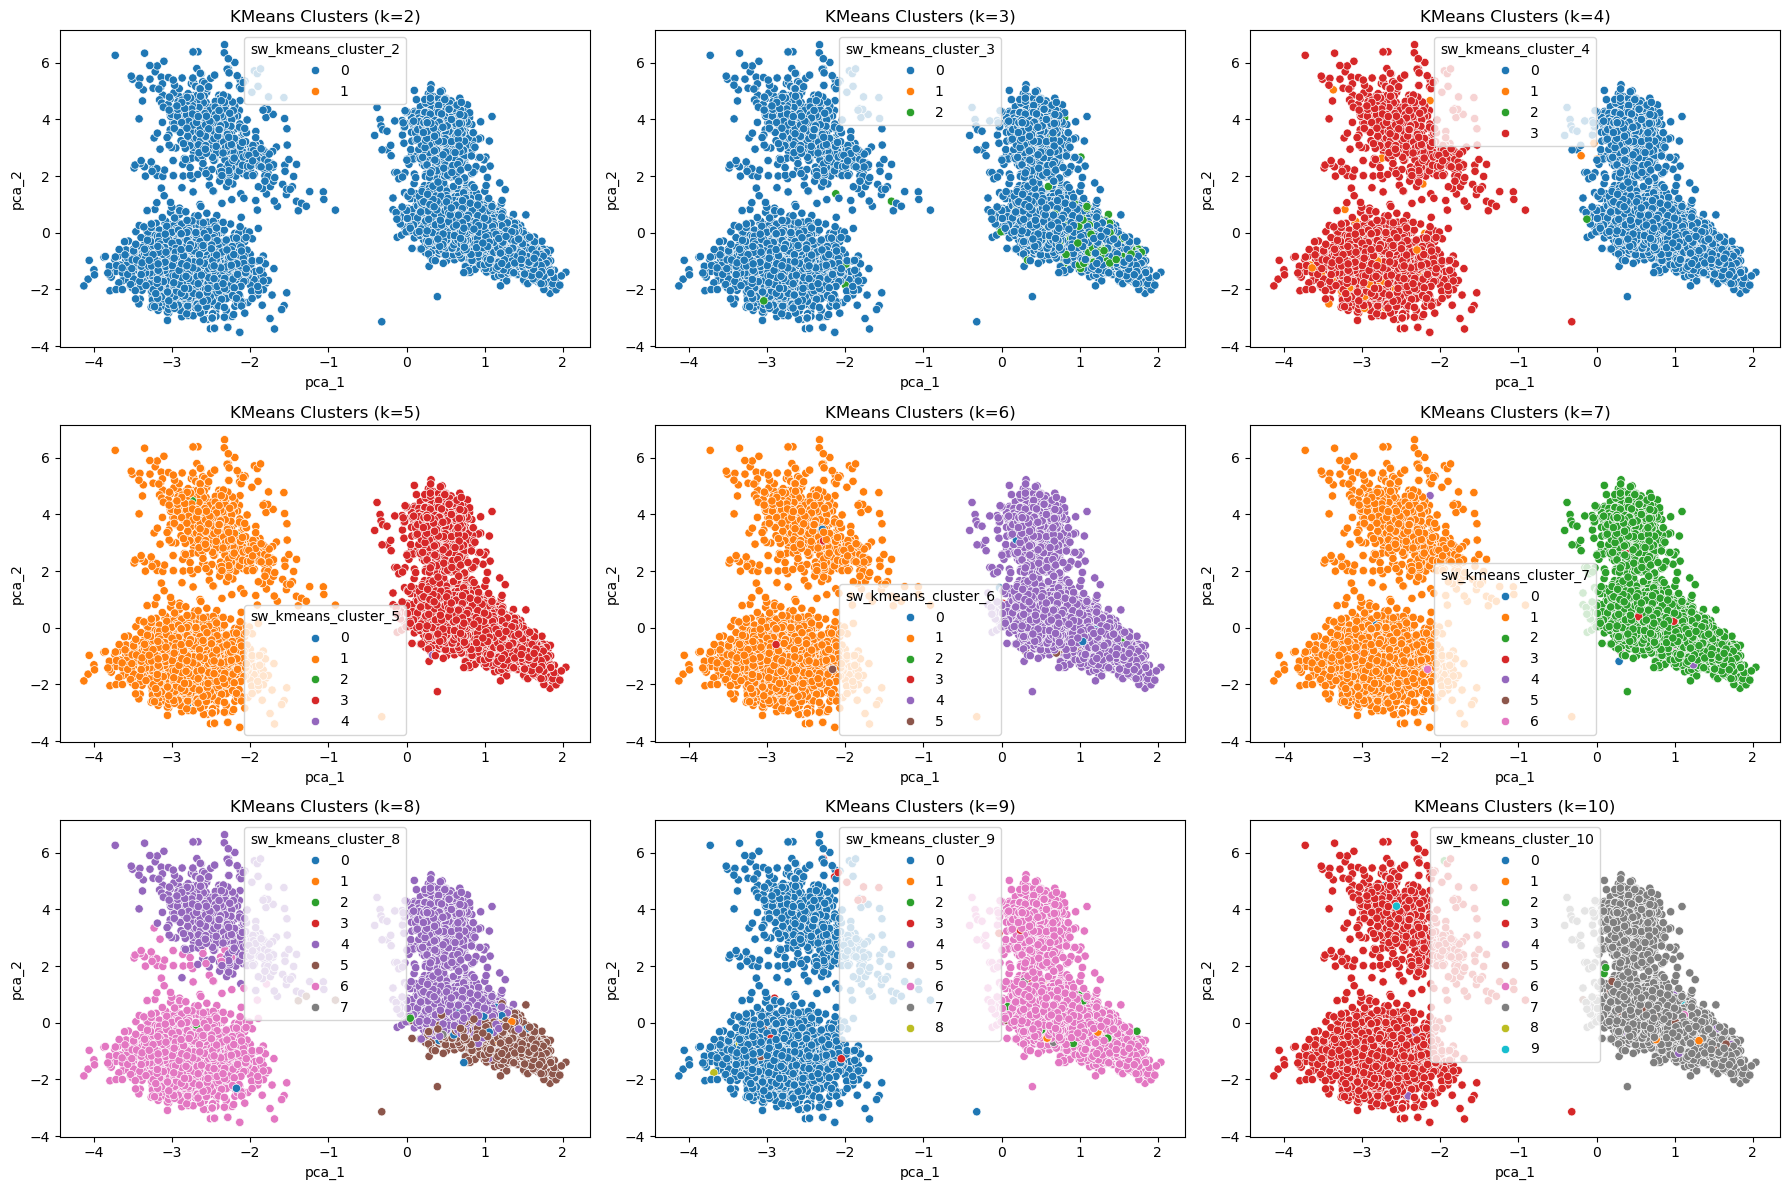

sw_kmeans_cluster_4  languages
0                    chi          8745
1                    chi            39
                     jpn            84
                     kor             9
2                    chi             1
                     jpn             2
3                    jpn          2397
                     kor           672
Name: key, dtype: int64

In [27]:
k_range = range(2, 11)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, k in enumerate(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df_encoded[f"sw_kmeans_cluster_{k}"] = kmeans.fit_predict(X_scaled_stopwords)

    sns.scatterplot(
        x=df_encoded["pca_1"],
        y=df_encoded["pca_2"],
        hue=df_encoded[f"sw_kmeans_cluster_{k}"],
        palette="tab10",
        ax=axes[i]
    )
    
    axes[i].set_title(f"KMeans Clusters (k={k})")

plt.tight_layout()
plt.show()

df_encoded.groupby(["sw_kmeans_cluster_4", "languages"])["key"].nunique()

#### KMeans with `k=4`

In [28]:
df_encoded["sw_kmeans_cluster_4"].value_counts()

sw_kmeans_cluster_4
0    8745
3    3069
1     132
2       3
Name: count, dtype: int64

## Analysis

### The Bigger Picture

The imbalance in the clusters could indicate a certain specificity in each type of East Asian literature. We see the largest cluster Chinese-Dominant Literature as a homogenous group with no books written in a different language. This cluster could indicate that these books are very specific to Chinese culture. The second largest cluster contains Japanese-Korean Literature. The fact that this cluster combined books written in Japanese and Korean points towards some kind of relationship between topics that are covered by both cultures. The remaining two clusters show more diversity but are very small in size when compared to the first two. There is the Mixed East Asian Literature and then the Sparse Chinese-Japanese Cluster. These could represent an edge case in clustering where language isn’t the primary differentiator.

In [29]:
df_encoded.groupby(["sw_kmeans_cluster_4", "languages"])["key"].nunique()

sw_kmeans_cluster_4  languages
0                    chi          8745
1                    chi            39
                     jpn            84
                     kor             9
2                    chi             1
                     jpn             2
3                    jpn          2397
                     kor           672
Name: key, dtype: int64

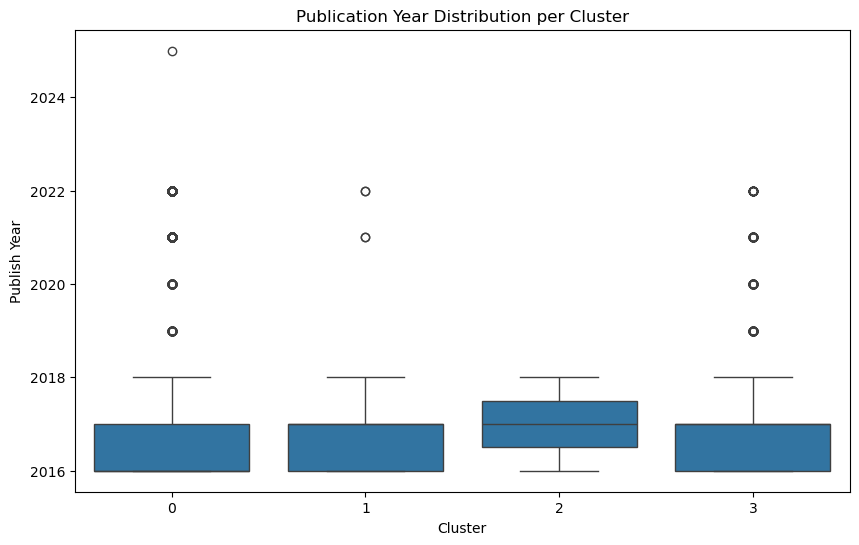

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_encoded, x="sw_kmeans_cluster_4", y="publish_year")
plt.xlabel("Cluster")
plt.ylabel("Publish Year")
plt.title("Publication Year Distribution per Cluster")
plt.show()

The majority of publications peaked between 2016 and 2017, with Cluster 0 experiencing the highest volume, followed by Cluster 3. In contrast, Clusters 1 and 2 had significantly lower publication volumes, with only a few scattered releases over the years.

This suggests that 2016-2017 marked a major publishing wave. The slowdown in publishing from 2020 onwards may have been brought about by the pandemic. Clusters 1 and 2 appear to represent niche categories that did not receive the same level of publishing attention.

In [65]:
terms = np.array(vectorizer.get_feature_names_out())

df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
df_tfidf["cluster"] = df_encoded["sw_kmeans_cluster_4"]

cluster_keywords = df_tfidf.groupby("cluster").mean().T

top_words_per_cluster = {}
for cluster in cluster_keywords.columns:
    top_words_per_cluster[cluster] = cluster_keywords[cluster].nlargest(10).index.tolist()

for cluster, words in top_words_per_cluster.items():
    print(f"Cluster {cluster} Top Words: {', '.join(words)}\n")

Cluster 0 Top Words: fiction, chinese, ji, xue, xiao, and, juvenile, yi, zi, li

Cluster 1 Top Words: short, stories, japanese, mystery, fiction, chinese, korean, murder, ni, interpersonal

Cluster 2 Top Words: miso, cooking, mainichi, aspects, isha, nagaiki, health, ceng, longevity, 5

Cluster 3 Top Words: fiction, japanese, and, juvenile, books, korean, history, guidebooks, stories, comic



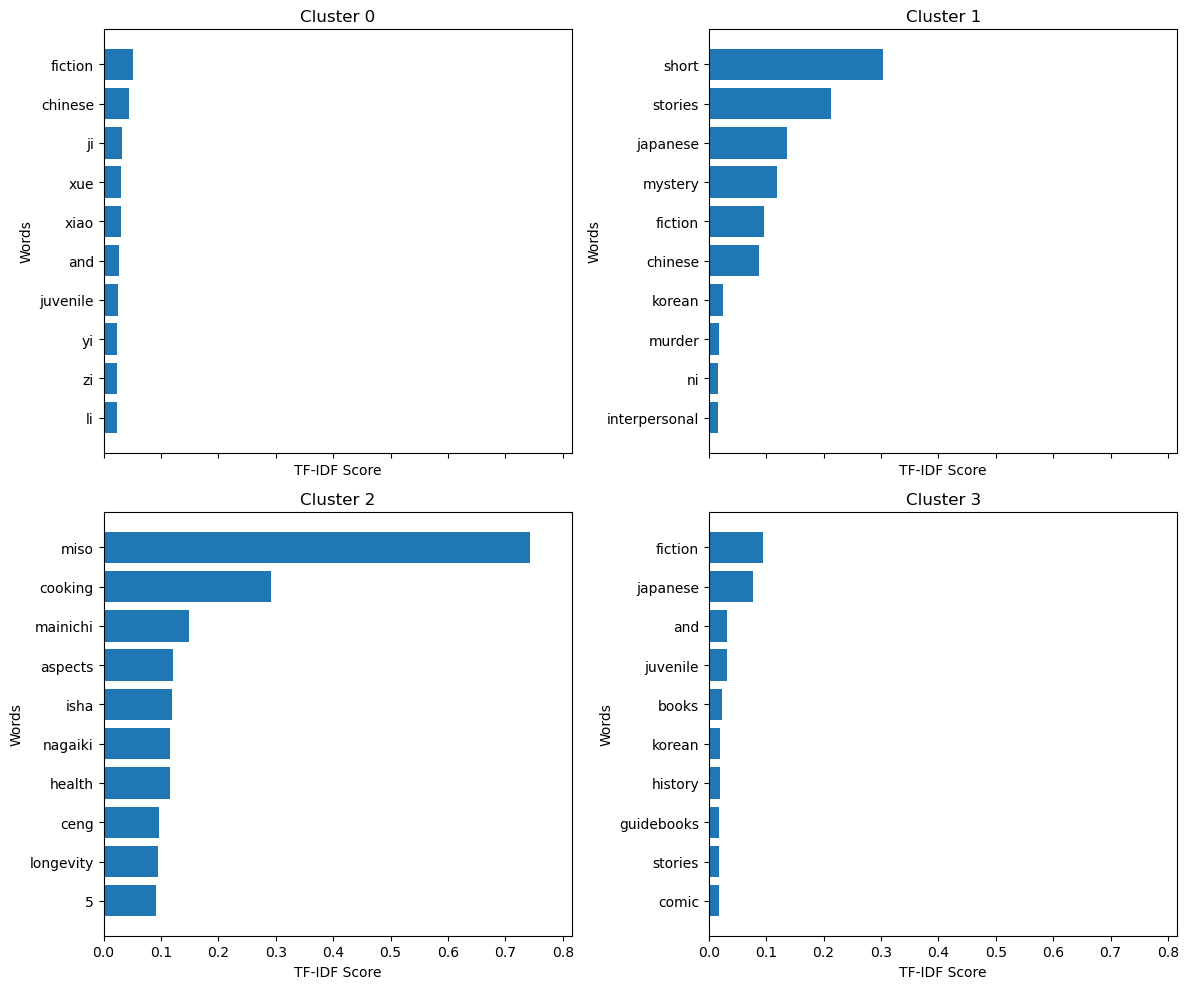

In [66]:
num_clusters = len(top_words_per_cluster.keys())

max_score = max(cluster_keywords.max())

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for idx, (cluster, ax) in enumerate(zip(top_words_per_cluster.keys(), axes)):
    top_words = top_words_per_cluster[cluster]
    top_scores = cluster_keywords.loc[top_words, cluster]
    
    ax.barh(top_words[::-1], top_scores[::-1])
    ax.set_xlabel("TF-IDF Score")
    ax.set_ylabel("Words")
    ax.set_title(f"Cluster {cluster}")
    # ax.grid(axis="x", linestyle="--", alpha=0.7)
    ax.set_xlim(0, max_score*1.1)

plt.tight_layout()
plt.show()

Clusters 0 and 1 are primarily focused on literature and fiction. Cluster 0 emphasizes Chinese literature, juvenile fiction, and travel, while Cluster 1 highlights Japanese and Korean short stories, mystery fiction, and interpersonal relationships. These clusters suggest a strong presence of East Asian storytelling that may have both traditional and modern themese.

Cluster 3 covers a broader scope, encompassing Japanese and Korean fiction, history, literature, and social issues. This distribution indicates a mix of specialized and general literary themes across the clusters. Cluster 2 stands out with a focus on food and health, particularly Japanese miso soup and longevity-related topics.

### Summary Table: East Asian Book Clusters

| **Cluster** | **Name**                        | **Themes**                                      | **Dominant Languages**         | **Key Words**                                    | **Publication Years** |
|------------|--------------------------------|------------------------------------------------|--------------------------------|------------------------------------------------|----------------------|
| **0**      | **Chinese Fiction & Education** | Chinese literature, juvenile fiction, travel, education-related topics | Mostly **Chinese**, some Korean | Fiction, ji, xue, xiao, travel, zhi, jiao | **2016-2018** |
| **1**      | **Mystery & Thriller Stories** | Short stories, mystery fiction, social relationships | **Chinese, Japanese, Korean** | Mystery, murder, interpersonal, relations, social, shuo | **2016-2025** |
| **2**      | **Food & Health Guides** | Cooking, health, longevity, Japanese food culture | Mostly **Japanese**, some Chinese | Miso, cooking, health, longevity, soups | **2016-2017** |
| **3**      | **Japanese & Korean Literature** | General fiction, history, comic strips, children's books | **Japanese, Korean** | Fiction, history, guidebooks, comic strips, literature | **2016-2018** |                                                                        

### Analysis over Time

In [68]:
# Initialize dictionary to store top words per cluster per year
top_words_per_year_cluster = {}
df_tfidf["publish_year"] = df_encoded["publish_year"]
# Loop through each year
for year in sorted(df_tfidf["publish_year"].dropna().unique()):
    year_group = df_tfidf[df_tfidf["publish_year"] == year].drop(columns=["publish_year"])
    
    if not year_group.empty:
        # Calculate mean TF-IDF scores for each word within the year
        yearly_keywords = year_group.groupby("cluster").mean().T
        
        # Store the top 15 words per cluster for the given year
        top_words_per_year_cluster[year] = {
            cluster: yearly_keywords[cluster].nlargest(10).index.tolist()
            for cluster in yearly_keywords.columns
        }

Year: 2016
  Cluster 0: fiction, chinese, xue, ji, xiao, li, yu, and, zi, jiao
  Cluster 1: short, stories, japanese, mystery, fiction, chinese, ni, xiao, korean, interpersonal
  Cluster 2: miso, mainichi, cooking, 0, 04, 1, 10, 100, 1000, 101
  Cluster 3: fiction, japanese, juvenile, and, guidebooks, books, history, comic, strips, stories
Year: 2017
  Cluster 0: fiction, chinese, juvenile, ji, yi, and, travel, zi, xiao, xue
  Cluster 1: short, stories, japanese, mystery, chinese, fiction, american, investigation, chuberōzu, matteru
  Cluster 2: miso, cooking, ceng, 5, soups, fen, tang, aspects, health, wei
  Cluster 3: fiction, japanese, juvenile, and, books, korean, children, life, stories, history
Year: 2018
  Cluster 0: fiction, chinese, drama, zhi, ji, travel, xiao, television, time, shou
  Cluster 1: korean, short, saram, nae, social, stories, materials, conditions, ke, customs
  Cluster 2: miso, isha, nagaiki, cooking, longevity, aspects, health, 0, 04, 1
  Cluster 3: drama, kor

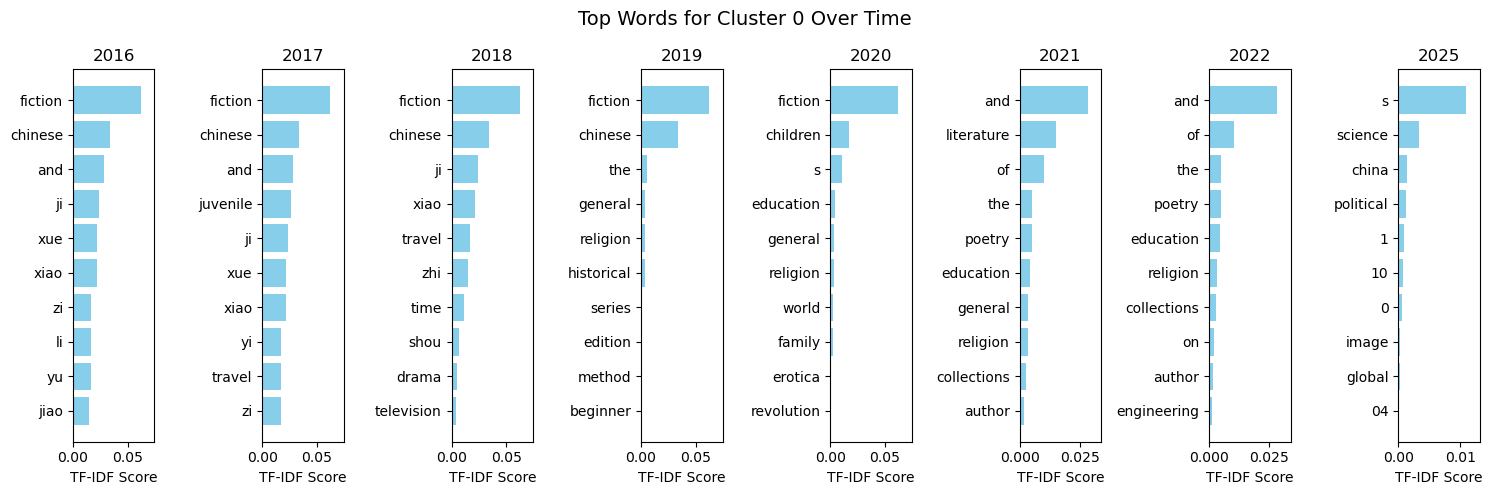

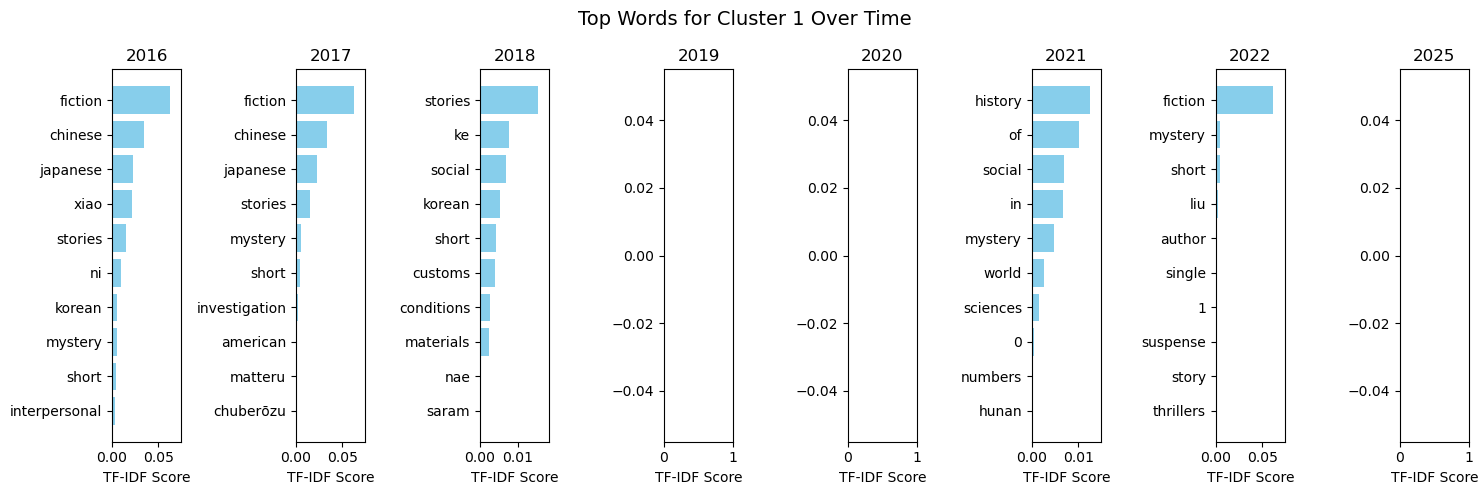

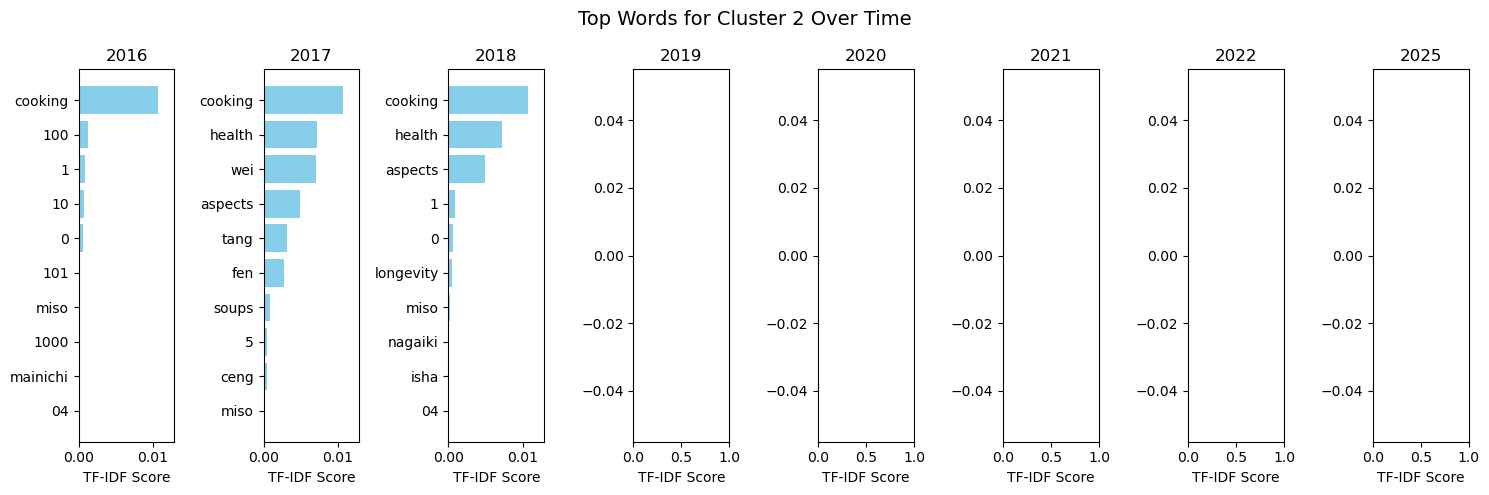

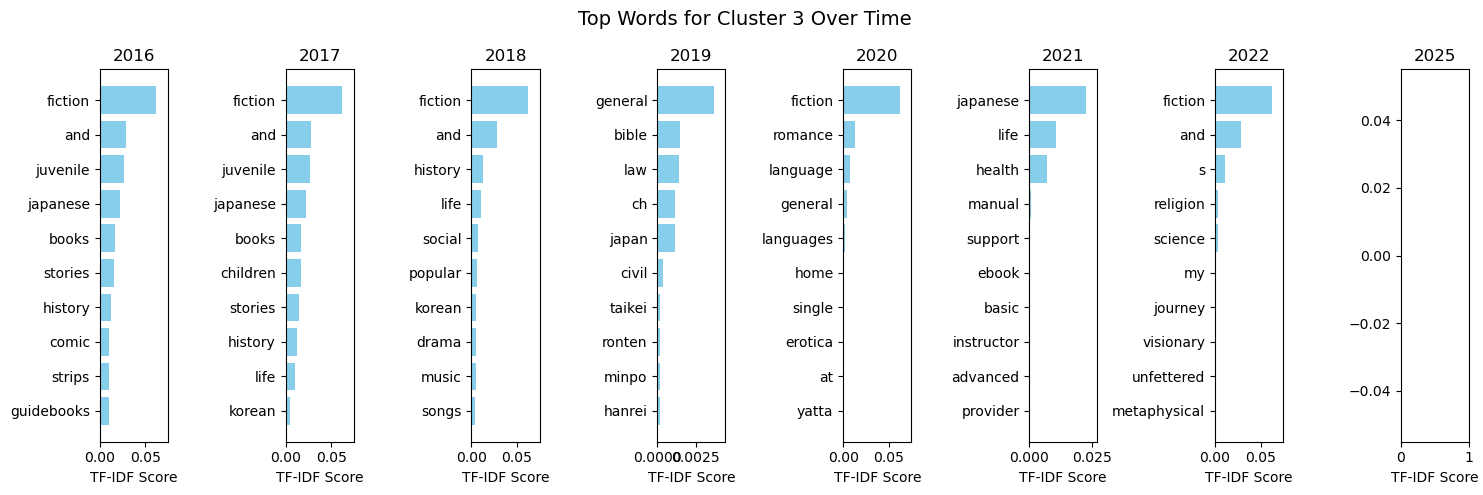

In [73]:
clusters = sorted(set(cluster for year in top_words_per_year_cluster for cluster in top_words_per_year_cluster[year]))
years = sorted(top_words_per_year_cluster.keys())

for cluster in clusters:
    fig, axes = plt.subplots(1, len(years), figsize=(15, 5))
    
    if len(years) == 1:
        axes = [axes]
    
    for i, year in enumerate(years):
        ax = axes[i]
        
        words = top_words_per_year_cluster[year].get(cluster, [])
        values = [df_tfidf[word].mean() for word in words] if words else []
        
        sorted_indices = sorted(range(len(values)), key=lambda i: values[i], reverse=False)
        words = [words[i] for i in sorted_indices]
        values = [values[i] for i in sorted_indices]
        
        ax.barh(words, values, color="skyblue")
        ax.set_title(f"{year}")
        ax.set_xlabel("TF-IDF Score")
        ax.set_xlim(0, max(values) * 1.2 if values else 1)
    
    fig.suptitle(f"Top Words for Cluster {cluster} Over Time", fontsize=14)
    plt.tight_layout()
    
    plt.show()


Cluster 0 (Chinese Fiction & Education) initially centered on Chinese fiction and juvenile literature, with recurring themes of storytelling, travel, and historical pieces. Over time, its focus broadened to include education, religion, and poetry, which is a shift toward more scholarly materials. By 2025, the cluster had moved toward science, politics, and global issues.

Cluster 3 (Japanese & Korean Literature) began with a strong emphasis on East Asian fiction, particularly Japanese and Korean literature, history, drama, and comic strips. Around 2019, the themes shifted toward law, civil rights, and religion, which could indicate the growing interest in philosophical and societal structures. In the later years, the cluster evolved further into science, metaphysics, and personal exploration. That means it might have moved from entertainment-based books to more intellectually engaging content.

## Conclusion

Overall, the clusters show clear differences in themes and focus over time. Cluster 0 (Chinese Fiction & Education), made up of Chinese books, moved from fiction and juvenile literature to more academic and global topics, showing a shift in interests. Cluster 3 (Japanese & Korean Literature), which includes Japanese and Korean books, started with fiction and history but later leaned toward deeper subjects like law, religion, and personal growth. Cluster 1 (Mystery & Thriller Stories), a mix of all three languages, suggests some common themes across cultures, while Cluster 2 (Food & Health Guides) remains a small outlier focused on food and health. The publishing peak in 2016-2017 highlights an active period for East Asian literature, followed by a decline, possibly due to external factors like the pandemic. These patterns reflect how literary trends evolve over time as they are shaped by both cultural and social changes.

### Limitations and Recommendations for Future Work

One limitation of this study is that TF-IDF captures term frequency but lacks deeper context and sentiment analysis. Future research could apply topic modeling (LDA) or word embeddings (Word2Vec) to gain richer thematic insights.

Another constraint is the limited timeframe (2016–2025), which may reflect short-term trends influenced by external factors like the pandemic. Expanding the dataset to include earlier and real-time publications would provide a more comprehensive view of literary evolution.

The study also does not account for reader reception or market demand. While publication trends highlight supply-side changes, they do not reveal whether these themes gained popularity. Future research could analyze book sales data, online reviews, or even social listening data to assess audience preferences.

The clustering approach assumes distinct categories, but books may have multiple themes. Using hierarchical clustering or mixed-membership models could allow for more flexible classifications.

Finally, comparing East Asian literary trends with global trends could determine whether these shifts are region-specific or part of a larger international movement. Addressing these limitations would provide a more refined understanding of how literature evolves and how external factors shape publishing trends.

## Disclaimer
Some parts of the markdown write up were generated using ChatGPT